# indolem/indobertweet-base-uncased

In [1]:
#https://huggingface.co/indobenchmark/indobert-base-lite-p2
!pip install transformers

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Dec 20 09:12:24 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   45C    P8             12W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
%pip install ntlk

ERROR: Could not find a version that satisfies the requirement ntlk (from versions: none)
ERROR: No matching distribution found for ntlk
Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install PySastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 kB 5.7 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [5]:
import nltk

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


True

In [6]:
!pip install datasets

In [7]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification,AutoModel,BertTokenizer,AutoConfig
from transformers import TrainingArguments
from transformers import Trainer
from transformers import pipeline
# from datasets import load_metric
# from datasets import load_dataset
from datasets import Dataset
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np

In [8]:
#Loading the data train .txt file
# df = pd.read_csv("/content/gdrive/MyDrive/ColabNotebooks/Chatbot/Experimen 3/Data/Dataset/Train/Dataset Tokopedia Review - Train (Semicolon Delimited).txt" , sep=';',encoding= 'unicode_escape')
# df = pd.read_csv("sample_data/PRDECT-ID.csv" , encoding='ISO-8859-1')
df = pd.read_csv('/kaggle/input/product-review/PRDECT-ID.csv')
# df.set_index(["labelEmotions","category","reviewText"]).count(level="labelEmotions")
df.set_index(["Emotion","Category","Customer Review"]).value_counts('Emotion')

Emotion
Happy      1770
Sadness    1202
Fear        920
Love        809
Anger       699
Name: count, dtype: int64

In [9]:
# kamus_alay = pd.read_csv("sample_data/kamusalay.csv" , encoding='ISO-8859-1',header = None)
kamus_alay = pd.read_csv('/kaggle/input/product-review/kamusalay.csv', encoding='ISO-8859-1', header = None)
kamus_alay_dict = kamus_alay.set_index(0).to_dict('dict')[1]
kamus_alay_dict

{'anakjakartaasikasik': 'anak jakarta asyik asyik',
 'pakcikdahtua': 'pak cik sudah tua',
 'pakcikmudalagi': 'pak cik muda lagi',
 't3tapjokowi': 'tetap jokowi',
 '3x': 'tiga kali',
 'aamiin': 'amin ',
 'aamiinn': 'amin',
 'aamin': 'amin',
 'aammiin': 'amin',
 'abis': 'habis',
 'abisin': 'habiskan',
 'acau': 'kacau',
 'achok': 'ahok',
 'ad': 'ada',
 'adek': 'adik ',
 'adl': 'adalah',
 'adlah': 'adalah',
 'adlh': 'adalah ',
 'ado': 'ada',
 'aduhh': 'aduh',
 'aer': 'air ',
 'afdol': 'afdal',
 'agamaataualqur': 'agama alquran',
 'agm': 'agama',
 'agma': 'agama',
 'ahaha': 'haha',
 'ahahaha': 'haha',
 'ahehehehe': 'hehe',
 'ahir': 'akhir',
 'ahirnya': 'akhirnya',
 'ahk': 'ahok',
 'ahlamdulillah': 'alhamdulillah',
 'ahli2': 'para ahli',
 'ahlusunnah': 'ahlus sunah',
 'ahmaddani': 'ahmad dhani',
 'aho': 'ahok',
 'ahoax': 'ahok',
 'ahoaxx': 'ahok',
 'ahog': 'ahok',
 'ahokataudjarot': 'ahok djarot',
 'ahokbebanijokowi': 'ahok beban jokowi',
 'ahokbtp': 'ahok basuki tjahaja purnama',
 'ahokdito

In [10]:
#rename column
# df=df[['reviewText','labelEmotions']]
# df=df.rename(columns={"reviewText": "text", "labelEmotions": "label"})

df=df[['Customer Review','Emotion']]
df=df.rename(columns={"Customer Review": "text", "Emotion": "label"})
df.head()

,text,label
0,Alhamdulillah berfungsi dengan baik. Packaging...,Happy
1,"barang bagus dan respon cepat, harga bersaing ...",Happy
2,"barang bagus, berfungsi dengan baik, seler ram...",Happy
3,bagus sesuai harapan penjual nya juga ramah. t...,Happy
4,"Barang Bagus, pengemasan Aman, dapat Berfungsi...",Happy


In [11]:
import string
import regex as re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

In [12]:
def process_cleaning(text):

    # remove emoji spesifik, angka, url dulu
    text_cleaning_re = r"rt|url|[^\w\s]|'|nbsp|https\S+|[0-9]+"
    text_sub = re.sub(text_cleaning_re, ' ', str(text))

    # Remove strip / trims
    text_strip = text_sub.strip()

    # remove punctutation/simbolll
    translator = str.maketrans('', '', string.punctuation)
    text_no_punct = text_strip.translate(translator)

    # Lower Case
    text_lower = text_no_punct.casefold()

    # tokenize
    text_token_stan = word_tokenize(text_lower)

    word_dict = []
    for word in text_token_stan:
        word_dict.append(kamus_alay_dict.get(word, word))
    tokens = " ".join(word_dict)

    # tambah kata singkatan =
    more_stopword = ["sih","nya"]

    # menampung stopword ke variabel untuk jadi operator remove stopword
    stopword_user = StopWordRemoverFactory().get_stop_words() + more_stopword
    # stopword_user = StopWordRemoverFactory().get_stop_words()

    # alternatif untuk perbaiki akurasi
    token_new = word_tokenize(tokens)
    filter_new = []
    filter_new2 = [word.strip() for word in token_new]
    filter_new = [word for word in filter_new2 if not word in stopword_user]
    tokens = " ".join(filter_new)

    return tokens

In [13]:
import numpy as np
import string

# data['cleaned without dict'] = data['Customer Review'].apply(process_cleaning2)
df['text'] = df['text'].apply(process_cleaning)
# print(list(data["processed_cleaning"]))

# x_cleaned = data['cleaned']
x_cleaned = df['text']
# x_cleaned2 = data['cleaned without dict']
# x_cleaned = data["cleaned"].values
df.head(10)

,text,label
0,alhamdulillah berfungsi packaging aman respon ...,Happy
1,barang bagus respon cepat harga bersaing,Happy
2,barang bagus berfungsi seler ramah pengiriman ...,Happy
3,bagus sesuai harapan penjual ramah terima kasi...,Happy
4,barang bagus pengemasan aman berfungsi,Happy
5,barang bagus seller ramah,Happy
6,mantap paten joss,Happy
7,works fine respon seller cepat barang berfungs...,Happy
8,barang bagus segel utuh original berfungsi sel...,Happy
9,barang berfungsi bagus lampu birunya,Happy


In [14]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter

In [15]:
#encode label
# def label2id (row):
#   if row['label'] == "Sadness":
#     return 0
#   if row['label'] == "Anger" :
#     return 1
#   if row['label'] == "Love" :
#     return 2
#   if row['label'] == "Fear":
#     return 3
#   if row['label'] == "Happy":
#     return 4

print(Counter(df['label']))
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])
# # print(data["emotion"].value_counts())
print(Counter(df['label']))
y_replaced = df['label']
print(y_replaced)

Counter({'Happy': 1770, 'Sadness': 1202, 'Fear': 920, 'Love': 809, 'Anger': 699})
Counter({2: 1770, 4: 1202, 1: 920, 3: 809, 0: 699})
0       2
1       2
2       2
3       2
4       2
       ..
5395    3
5396    3
5397    2
5398    2
5399    3
Name: label, Length: 5400, dtype: int64


In [16]:
df.head(5)

,text,label
0,alhamdulillah berfungsi packaging aman respon ...,2
1,barang bagus respon cepat harga bersaing,2
2,barang bagus berfungsi seler ramah pengiriman ...,2
3,bagus sesuai harapan penjual ramah terima kasi...,2
4,barang bagus pengemasan aman berfungsi,2


In [17]:
from sklearn.model_selection import train_test_split

# x_train, x_test, y_train, y_test = train_test_split(x_cleaned, y_replaced, test_size=0.2, random_state=225)

In [18]:
train_valid_ratio = 0.80
train_test_ratio = 0.20

#train test split
df_train, df_test = train_test_split(df, test_size = train_test_ratio, random_state = 42)
print("Train Shape",df_train.shape)
print("Test Shape",df_test.shape)

print(df_train)
#train valid split
# df_train, df_valid = train_test_split(df_train, train_size = train_valid_ratio, random_state = 42)
# print("Train Shape",df_train.shape)
# print("Valid Shape",df_valid.shape)

Train Shape (4320, 2)
Test Shape (1080, 2)
                                                   text  label
4148  barangnya terima pecah sudut posisi dilapis ga...      4
2809  masker bagus bahannya nyaman gampang kusut pes...      4
621   produk sesuai pengiriman cepat harganya ribu p...      2
566                   dendeng daging sapi asli campuran      1
1957                                    mantap pokoknya      3
...                                                 ...    ...
3772  teliti kiraan produk asli ex australia ex kalb...      1
5191  barangnya bagus tebal best deal kemarin mama s...      3
5226         kualitas produk bagus respon penjual ramah      2
5390  sip paket selamat semoga berfungsi terima kasi...      2
860                       barang sesuai pc liter kecewa      4

[4320 rows x 2 columns]


In [19]:
# df['labelEncoded'] = df.apply(lambda row: label2id(row), axis=1)
# df=df.rename(columns={"label": "emotions", "labelEncoded": "label"})
# print(df.head())
# label_reference=df[['emotions','label']].copy().drop_duplicates()
# print(label_reference)

In [20]:
# df=df.rename(columns={"label": "emotions", "labelEncoded": "label"})
print(df.head())
# label_reference=df[['emotions','label']].copy().drop_duplicates()
# print(df[['emotions','label']].copy().drop_duplicates())
# print(df['Emotion'].copy().drop_duplicates())
# print(df['label'].copy().drop_duplicates())
# print(df.rename(columns={'label': 'emotions', 'labelEncoded': 'label'}))
# print(df['label'].drop_duplicates())
print(df['label'])
pd.concat

                                                text  label
0  alhamdulillah berfungsi packaging aman respon ...      2
1           barang bagus respon cepat harga bersaing      2
2  barang bagus berfungsi seler ramah pengiriman ...      2
3  bagus sesuai harapan penjual ramah terima kasi...      2
4             barang bagus pengemasan aman berfungsi      2
0       2
1       2
2       2
3       2
4       2
       ..
5395    3
5396    3
5397    2
5398    2
5399    3
Name: label, Length: 5400, dtype: int64


<function pandas.core.reshape.concat.concat(objs: 'Iterable[Series | DataFrame] | Mapping[HashableT, Series | DataFrame]', *, axis: 'Axis' = 0, join: 'str' = 'outer', ignore_index: 'bool' = False, keys: 'Iterable[Hashable] | None' = None, levels=None, names: 'list[HashableT] | None' = None, verify_integrity: 'bool' = False, sort: 'bool' = False, copy: 'bool | None' = None) -> 'DataFrame | Series'>

In [21]:
#prepare data train and validation
import pandas as pd
df_val = pd.DataFrame()


# pd.concat(df, ignore_index=True)
# print(range(df['label'].drop_duplicates()))
# df[df['label']]
# print(df[df['label']] == )
print(df_train.shape)
for row in df['label'].drop_duplicates():
  df_val = pd.concat([df_val, df_train.loc[df_train['label']==row]], ignore_index=True)
  # print(df.loc[df['label']==row])
# lanjut develop di sini
# df_train = df[~df.text.isin(df_val.text)].copy()
df_train = df_val
# print(df_val)
print(df_train.shape)
# df_train = df[~df.text.isin(df_val.text)].copy()
# df_train.shape
# print(df_train)
# df_train = df[~df.text.isin(df_val.text)].copy()
# print(df_train.shape)
# # df_train = pd.concat([])
# df_train
# for index,sentence in df[['label']].drop_duplicates().iterrows():
#   # df_val = pd.concat([df_val,df[df.loc['label']==sentence.item()].head(5)])
#   df_val=df_val.append(df[df['label']==sentence.item()].head(5))
#   # df_val=df_val.append(df.loc[df['label']==sentence.item()].head(5))
# df_train = df[~df.text.isin(df_val.text)].copy()

(4320, 2)
(4320, 2)


In [22]:
print(df_train)

                                                   text  label
0     produk sesuai pengiriman cepat harganya ribu p...      2
1     mantap murah terima kasih kak terima kasih aba...      2
2          respon cepat packing oke rapi orderan sesuai      2
3     barang sesuai ukuran mesin cuci tabung pas ter...      2
4     aplikator mudah dipakai desainnya lucu warnany...      2
...                                                 ...    ...
4315                                              nyala      1
4316  beli celana hitam grey merah muda ukuran beda ...      1
4317                            bangkai mati semuanyaaa      1
4318  butuh cepat kirim respon jual amanah brather j...      1
4319  teliti kiraan produk asli ex australia ex kalb...      1

[4320 rows x 2 columns]


In [23]:
#convert dataframe to dataset type
dataset_train = Dataset.from_dict(df_val)
dataset_val =  Dataset.from_dict(df_test)
print("Dataset Train : ",dataset_train)
print("Dataset Val : ",dataset_val)

Dataset Train :  Dataset({
    features: ['text', 'label'],
    num_rows: 4320
})
Dataset Val :  Dataset({
    features: ['text', 'label'],
    num_rows: 1080
})


#Load Pre-trained Model and Fine Tune

In [24]:
#konfigurasi penamaan label sesuai dengan kelas emoion yang digunakan
id2label = {
    "0": "Anger",
    "1": "Fear",
    "2": "Happy",
    "3": "Love",
    "4": "Sadness"
  }
label2id= {
    "Anger": 0,
    "Fear": 1,
    "Happy": 2,
    "Love": 3,
    "Sadness": 4
  }

In [25]:
# https://huggingface.co/indobenchmark/indobert-lite-base-p2
# https://huggingface.co/ayameRushia/indobert-base-uncased-finetuned-indonlu-smsa
config = AutoConfig.from_pretrained("indolem/indobertweet-base-uncased")

config.label2id = label2id
config.id2label = id2label
config._num_labels = len(label2id)

config.json:   0%|          | 0.00/1.10k [00:00<?, ?B/s]

In [26]:
tokenizer = AutoTokenizer.from_pretrained("indolem/indobertweet-base-uncased")
model = AutoModelForSequenceClassification.from_pretrained("indolem/indobertweet-base-uncased",config=config)
model.config

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/235k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobertweet-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "indolem/indobertweet-base-uncased",
  "_num_labels": 5,
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_ids": 0,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "Anger",
    "1": "Fear",
    "2": "Happy",
    "3": "Love",
    "4": "Sadness"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "Anger": 0,
    "Fear": 1,
    "Happy": 2,
    "Love": 3,
    "Sadness": 4
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.46.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 31923
}

In [27]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=512)

In [28]:
dataset_train = dataset_train.map(tokenize_function, batched=True)
dataset_val = dataset_val.map(tokenize_function, batched=True)

Map:   0%|          | 0/4320 [00:00<?, ? examples/s]

Map:   0%|          | 0/1080 [00:00<?, ? examples/s]

In [29]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [30]:
training_args = TrainingArguments("test_trainer", eval_strategy="epoch",per_device_train_batch_size=8,num_train_epochs=8,learning_rate=2e-5,logging_steps=1, report_to="none")
trainer = Trainer(model=model.cuda(), args=training_args, train_dataset=dataset_train, eval_dataset=dataset_val,compute_metrics=compute_metrics)
trainer.train()

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.897400,0.953606,0.604630,0.562313,0.577368,0.559183
2,0.497000,0.916997,0.619444,0.592498,0.591515,0.603091
3,0.583400,0.909134,0.646296,0.611133,0.628794,0.606473
4,0.679300,0.938891,0.631481,0.593124,0.597842,0.589978
5,0.590500,0.996938,0.641667,0.598955,0.621309,0.593007
6,0.494000,1.088886,0.635185,0.606164,0.609027,0.606686
7,0.223900,1.132257,0.621296,0.584976,0.593937,0.589016
8,0.277600,1.140497,0.625926,0.591396,0.597879,0.592317


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0

TrainOutput(global_step=2160, training_loss=0.5976460054861726, metrics={'train_runtime': 2063.6964, 'train_samples_per_second': 16.747, 'train_steps_per_second': 1.047, 'total_flos': 9093363003555840.0, 'train_loss': 0.5976460054861726, 'epoch': 8.0})

In [31]:
model.save_pretrained("indobert-base-uncased-model")
tokenizer.save_pretrained("indobert-base-uncased-model")

('indobert-base-uncased-model/tokenizer_config.json',
 'indobert-base-uncased-model/special_tokens_map.json',
 'indobert-base-uncased-model/vocab.txt',
 'indobert-base-uncased-model/added_tokens.json',
 'indobert-base-uncased-model/tokenizer.json')

In [32]:
tokenizer = AutoTokenizer.from_pretrained("/kaggle/working/indobert-base-uncased-model")
model = AutoModelForSequenceClassification.from_pretrained("/kaggle/working/indobert-base-uncased-model")
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31923, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [33]:
trainer.save_model('/kaggle/working/indobert-base-save_model')

In [34]:
trainer.evaluate()

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 1.1404974460601807,
 'eval_accuracy': 0.6259259259259259,
 'eval_f1': 0.5913964339681064,
 'eval_precision': 0.5978791294590159,
 'eval_recall': 0.5923174924550414,
 'eval_runtime': 19.6451,
 'eval_samples_per_second': 54.975,
 'eval_steps_per_second': 3.461,
 'epoch': 8.0}

In [35]:
#convert dataframe to dataset type
dataset_test= Dataset.from_dict(df_test)
dataset_test = dataset_test.map(tokenize_function, batched=True)

Map:   0%|          | 0/1080 [00:00<?, ? examples/s]

In [36]:
predicted_review = trainer.predict(dataset_test)
raw_pred, _, _ = predicted_review
predclas= np.argmax(raw_pred, axis=1)

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [37]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

Accuracy:  62.59259259259259
Precision:  59.78791294590159
Recall:  59.23174924550414
F1 score:  59.13964339681064
Classification Report:
              precision    recall  f1-score   support

           2     0.7424    0.7528    0.7476       356
           4     0.6296    0.6047    0.6169       253
           1     0.4462    0.5472    0.4915       159
           3     0.6328    0.6707    0.6512       167
           0     0.5385    0.3862    0.4498       145

    accuracy                         0.6259      1080
   macro avg     0.5979    0.5923    0.5914      1080
weighted avg     0.6280    0.6259    0.6244      1080



Text(50.722222222222214, 0.5, 'True Labels')

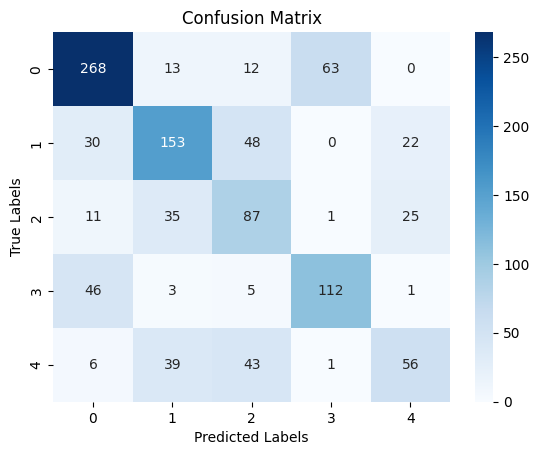

In [38]:
labels = df_test["label"].unique()
accuracy = accuracy_score(df_test['label'], predclas)
print('Accuracy: ', accuracy * 100)
precision = precision_score(df_test['label'], predclas, average='macro', zero_division=1)
print('Precision: ', precision * 100)
# recall: tp / (tp + fn)
recall = recall_score(df_test['label'], predclas, average='macro', zero_division=1)
print('Recall: ', recall * 100)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(df_test['label'], predclas, average='macro')
print('F1 score: ', f1 * 100)
print('Classification Report:')
print(classification_report(df_test['label'], predclas, labels=labels, digits=4))
cm = confusion_matrix(df_test['label'], predclas, labels=labels)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

ax.set_title('Confusion Matrix')

ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')